# Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation
## Combient's first predictive maintenance prototype


###  Data 

The datasets used in this example together all necessary information a list of related scientific publications are freely available on the NASA Ames Prognostics data repository (http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan) 


| Data Set | Train trjectories | Test trajectories | Conditions      | Fault Mode                             |
|----------|:-----------------:|------------------:|-----------------|----------------------------------------|
| FD001    |        100        |               100 | ONE (Sea Level) | ONE (HPC Degradation)                  |
| FD002    |        260        |               259 | SIX             | ONE (HPC Degradation)                  |
| FD003    |        100        |               100 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation) |
| FD004    |        248        |               249 | SIX             | TWO (HPC Degradation, Fan Degradation) |



## Experimental Scenario

Data sets consist of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

| Column| Train trjectories | 
|----------|:-----------------|
| 1    |        unit number        |   
| 2    |        time, in cycles        |     
| 3    |        operational setting 1        |   
| 4    |        operational setting 2        |             
| 5    |        operational setting 3        |           
| 6    |        sensor measurement  1        |              
| 7    |        sensor measurement  2        |             
| 26   |        sensor measurement  3        |              


References: 

1. A. Saxena, K. Goebel, D. Simon, and N. Eklund, "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation", in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008., retrieved feb. 2016
2. NASA Ames Prognostics data repository, retrieved feb. 2016, http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/
3. [Major Challenges in Prognostics: Study on Benchmarking Prognostics Datasets](https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2012/phmce_12_004.pdf), O. F. Eker1, F. Camci, and I. K. Jennions1, retrieved feb. 2016
4. [Big Data Analytics for eMaintenance : Modeling of high-dimensional data streams.](	
http://goo.gl/kgvoMt) / Zhang, Liangwei.
Luleå : Luleå tekniska universitet, 2015. 46 p. (Licentiate thesis / Luleå University of Technology).
Publication: Research › Licentiate thesis, retrieved feb. 2016
5. Microsoft Cortana example with the same dataset, retrieved feb. 2016 [Link](https://gallery.cortanaanalytics.com/Collection/Predictive-Maintenance-Template-3?share=1)
6. H2o.io example with the same dataset, retrieved feb. 2016
[Link](https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/python-munging-modeling-pipelines/Munging-Modeling-Pipelines-Using-H2O-Pipelines.ipynb) [Presentation](https://www.youtube.com/watch?v=KqLXFglgNqk)
7. Advanced Analytics with Spark - Patterns for Learning from Data at Scale By Sandy Ryza, Uri Laserson, Sean Owen, Josh Wills. [Link](http://shop.oreilly.com/product/0636920035091.do) [Examples](https://github.com/sryza/aas)



-----------------

-----------------



# Part 1 : Data exploration 

We will start by exploring the data by visualizing different aspects of it in onder to develop some intuition about the underlying problem. 


### Initiatlize Spark for Python and create an sqlContext

NB: the next block should  be run only once. It will cause an error if run a second time. 
If the error happens, select "Kernel/restart" from the menu bar.

In [1]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()   #This line is not always needed....
from pyspark.sql import SQLContext
from pyspark.sql.types import *
sqlContext = SQLContext(sc)

### Import the data
Make sure you have sucessfully run the script "run_PrepareAllData.sh" before executing the next block. This will read the parquet file prepared by the script. 

In [2]:
scaledDF = sqlContext.read.parquet('/share/tedsds/scaleddftrain_FD001')

In [3]:
scaledDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- cycle: integer (nullable = true)
 |-- setting1: double (nullable = true)
 |-- setting2: double (nullable = true)
 |-- setting3: double (nullable = true)
 |-- s1: double (nullable = true)
 |-- s2: double (nullable = true)
 |-- s3: double (nullable = true)
 |-- s4: double (nullable = true)
 |-- s5: double (nullable = true)
 |-- s6: double (nullable = true)
 |-- s7: double (nullable = true)
 |-- s8: double (nullable = true)
 |-- s9: double (nullable = true)
 |-- s10: double (nullable = true)
 |-- s11: double (nullable = true)
 |-- s12: double (nullable = true)
 |-- s13: double (nullable = true)
 |-- s14: double (nullable = true)
 |-- s15: double (nullable = true)
 |-- s16: double (nullable = true)
 |-- s17: double (nullable = true)
 |-- s18: double (nullable = true)
 |-- s19: double (nullable = true)
 |-- s20: double (nullable = true)
 |-- s21: double (nullable = true)
 |-- operationmode: integer (nullable = true)
 |-- rul: integer (nullable = 

Prepare a few lists to help manipulating the dataframe later on

In [4]:
# Setup the column names of the training file
index_columns_names =  ["id","cycle"]
operational_settings_columns_names = ["setting"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["s"+str(i) for i in range(1,22)]
sensor_measure_meancolumns_names =["a"+str(i) for i in range(1,22)]
sensor_measure_sdeccolumns_names =["sd"+str(i) for i in range(1,22)]

input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

# And the name of the to be engineered target variable
dependent_var = ['rul']

Use Spark to calculate basic statistics about the data

In [5]:
scaledDF.describe('setting1','setting2','setting3','s1','a1','sd1','rul', 's7', 's12', 's20').toPandas()

,summary,setting1,setting2,setting3,s1,a1,sd1,rul,s7,s12,s20
0,count,20631,20631,20631,20631,20631,20631,20631,20631,20631,20631
1,mean,-8.870146866366143E-6,2.3508312733265463E-6,100.0,518.669999999999,518.669999999999,0.0,107.80786195530997,553.3677112112839,521.4134700208422,38.81627066065631
2,stddev,0.0021873134490151456,2.93062124566145E-4,0.0,0.0,0.0,0.0,68.8809901772182,0.8850922576634046,0.7375533922096991,0.18074642787366074
3,min,-0.0087,-6.0E-4,100.0,518.67,518.67,0.0,0,549.85,518.69,38.14
4,max,0.0087,6.0E-4,100.0,518.67,518.67,0.0,361,556.06,523.38,39.43


Note that setting3 never changes!

### Take a random subset of the data
In the next block, we use spark to select a subset of the column in the data and a random subset of rows. The method .toPanda() then gather all the data on the local node and converts it to a panda DataFrame that can be analyze in Python without any reference to Spark.

In [6]:
fraction = 1000.0 / scaledDF.count()
pf = scaledDF.select(dependent_var+operational_settings_columns_names+sensor_measure_columns_names).sample(fraction=fraction, withReplacement=False, seed=123456).toPandas()

### Import and configure Python library for data manipulation and plotting

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#Show the plots inside the notebook
%matplotlib inline  

sns.set() 

def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)


### Visualize some aspects of the data

Plot a histogram of the distribution of values of a column and the corresponding kernel density estimate on the same plot

See https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.distplot.html

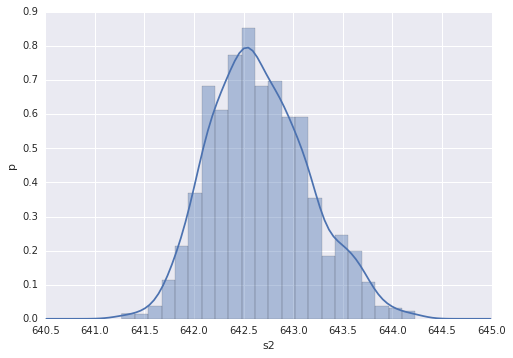

In [8]:
ax = sns.distplot(pf[["s2"]])
labels("s2", "p", ax)

Calculate correlations between each pairs of columns in the sub-sampled data  and plot it

In [9]:
pf_corr = pf.corr(method='pearson')
pf_corr

,rul,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
rul,1.000000e+00,3.941810e-02,-2.013409e-02,NaN,-1.231836e-16,-6.624573e-01,-5.778602e-01,-6.892808e-01,2.872878e-16,-1.204324e-01,...,6.984828e-01,-5.735626e-01,-2.886305e-01,-6.601166e-01,2.774372e-16,-6.302951e-01,NaN,NaN,6.481632e-01,6.421476e-01
setting1,3.941810e-02,1.000000e+00,1.174338e-01,NaN,1.461191e-18,2.315328e-03,-5.634903e-02,-5.775475e-02,-9.333576e-18,4.412012e-03,...,4.865301e-02,-2.290079e-02,-3.132184e-02,-2.104336e-02,6.113014e-18,-1.748884e-02,NaN,NaN,2.162970e-02,3.677506e-03
setting2,-2.013409e-02,1.174338e-01,1.000000e+00,NaN,3.280457e-17,5.663889e-02,3.381729e-02,4.172080e-02,4.621525e-18,1.849490e-02,...,-5.954993e-02,8.739766e-02,-5.879195e-02,6.129014e-02,-2.883405e-17,6.327266e-02,NaN,NaN,-5.589231e-02,-6.119036e-02
setting3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s1,-1.231836e-16,1.461191e-18,3.280457e-17,NaN,1.000000e+00,-6.114248e-13,2.520547e-13,-7.554850e-14,-1.000000e+00,-2.125343e-10,...,8.803658e-13,-8.448007e-11,6.060870e-13,3.121571e-14,-1.000000e+00,-6.265046e-15,NaN,NaN,-1.225440e-14,-2.381014e-13
s2,-6.624573e-01,2.315328e-03,5.663889e-02,NaN,-6.114248e-13,1.000000e+00,6.077469e-01,7.308778e-01,6.114277e-13,9.130557e-02,...,-7.491408e-01,6.911455e-01,1.715173e-01,7.123176e-01,6.114179e-13,6.282399e-01,NaN,NaN,-6.938897e-01,-6.734623e-01
s3,-5.778602e-01,-5.634903e-02,3.381729e-02,NaN,2.520547e-13,6.077469e-01,1.000000e+00,6.853349e-01,-2.520731e-13,1.175885e-01,...,-6.817207e-01,6.067841e-01,1.992950e-01,6.525744e-01,-2.520331e-13,5.803557e-01,NaN,NaN,-6.103162e-01,-6.260920e-01
s4,-6.892808e-01,-5.775475e-02,4.172080e-02,NaN,-7.554850e-14,7.308778e-01,6.853349e-01,1.000000e+00,7.550511e-14,1.587325e-01,...,-8.093775e-01,7.281611e-01,1.916774e-01,7.608480e-01,7.547364e-14,6.868571e-01,NaN,NaN,-7.477550e-01,-7.423565e-01
s5,2.872878e-16,-9.333576e-18,4.621525e-18,NaN,-1.000000e+00,6.114277e-13,-2.520731e-13,7.550511e-14,1.000000e+00,2.125343e-10,...,-8.803813e-13,8.448007e-11,-6.060888e-13,-3.114729e-14,1.000000e+00,6.481527e-15,NaN,NaN,1.224215e-14,2.380759e-13
s6,-1.204324e-01,4.412012e-03,1.849490e-02,NaN,-2.125343e-10,9.130557e-02,1.175885e-01,1.587325e-01,2.125343e-10,1.000000e+00,...,-1.433655e-01,1.340415e-01,2.566258e-03,1.620603e-01,2.125343e-10,9.899976e-02,NaN,NaN,-1.469943e-01,-1.297701e-01


The formula for calculating the [Pearson Correlation][pearson] between two sets of data can be expressed as:

$$r = r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$$

This text is Markdown and rendered as a presentation via the [RISE][rise] Jupyter extension. In addition to basic Markdown, mathematics can be rendered which is useful when talking to a technical audience.

[rise]: https://github.com/damianavila/RISE
[pearson]: https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient

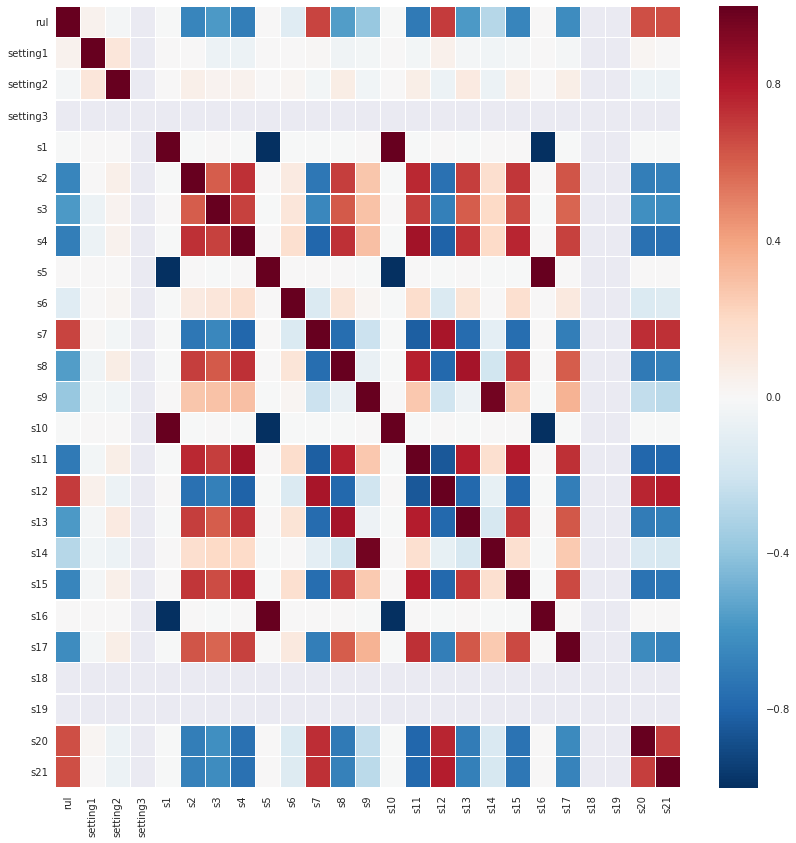

In [10]:
dims = (14,14)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(pf_corr,linewidths=.5);

Make a closer investigation of some pairs of variables
https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html#seaborn.jointplot

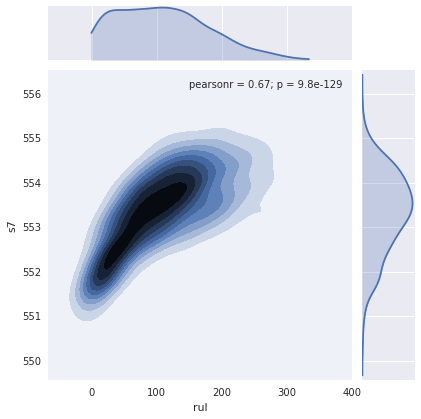

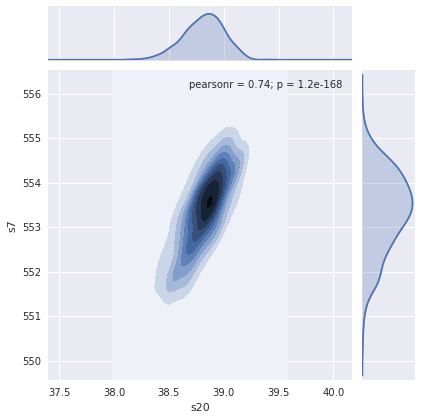

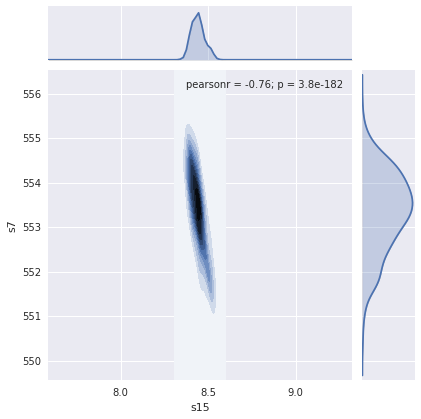

In [11]:
sns.jointplot("rul", "s7", data=pf, kind='kde')  
sns.jointplot("s20", "s7", data=pf, kind='kde')  
sns.jointplot("s15", "s7", data=pf, kind='kde')  

Another way of looking at the same data

https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.JointGrid.html#seaborn.JointGrid

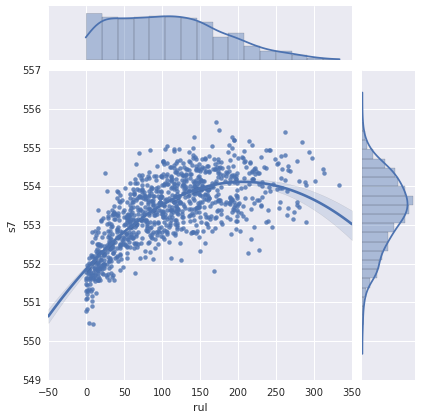

In [12]:
g = sns.JointGrid(x="rul", y="s7", data=pf)  
g.plot_joint(sns.regplot, order=2)  
g.plot_marginals(sns.distplot)  

Inspect the settings

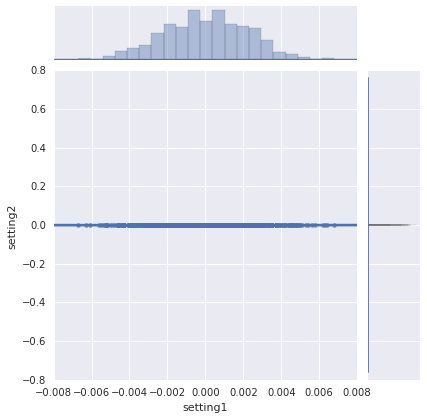

In [13]:
g = sns.JointGrid(x="setting1", y="setting2", data=pf)  
g.plot_joint(sns.regplot, order=2)  
g.plot_marginals(sns.distplot)  

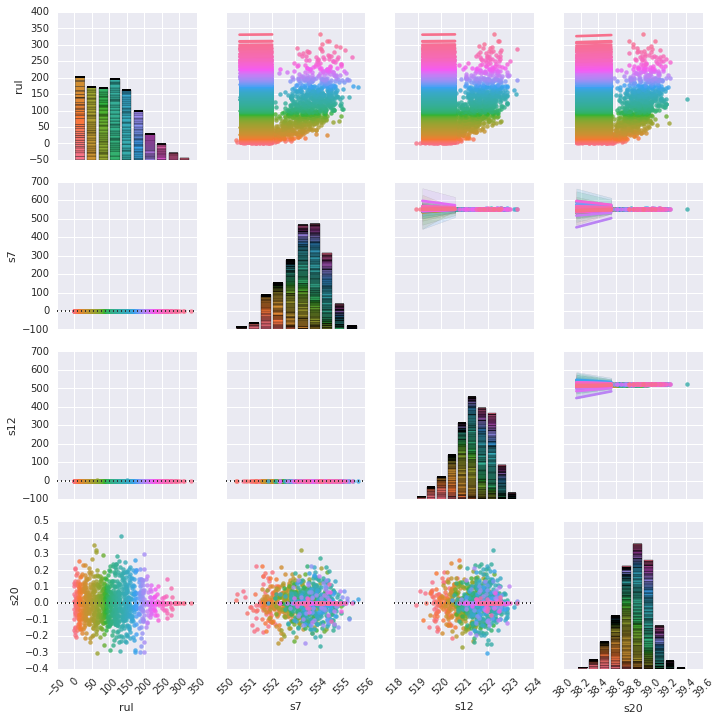

In [14]:
g = sns.PairGrid(pf[["rul", "s7", "s12", "s20"]], hue="rul", dropna=True)  
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)  
g.map_diag(plt.hist)  
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)
g.set(alpha=0.5)  

### Plot evolution of sensor data over time


Extract all engine IDs

In [15]:
IDs = scaledDF.select("id").toPandas()["id"].tolist()
IDs = list(set(IDs))  #Remove duplicate IDs from the list

Select 20 engines at random:

In [16]:
import random as rnd
import pandas as pd
data=pd.DataFrame()
IDlist = rnd.sample(IDs,20)
for i in IDlist:
    data = pd.concat([data,scaledDF.filter(scaledDF.id==i).toPandas()])

Plot time series for all sensors and settings of these 20 engines

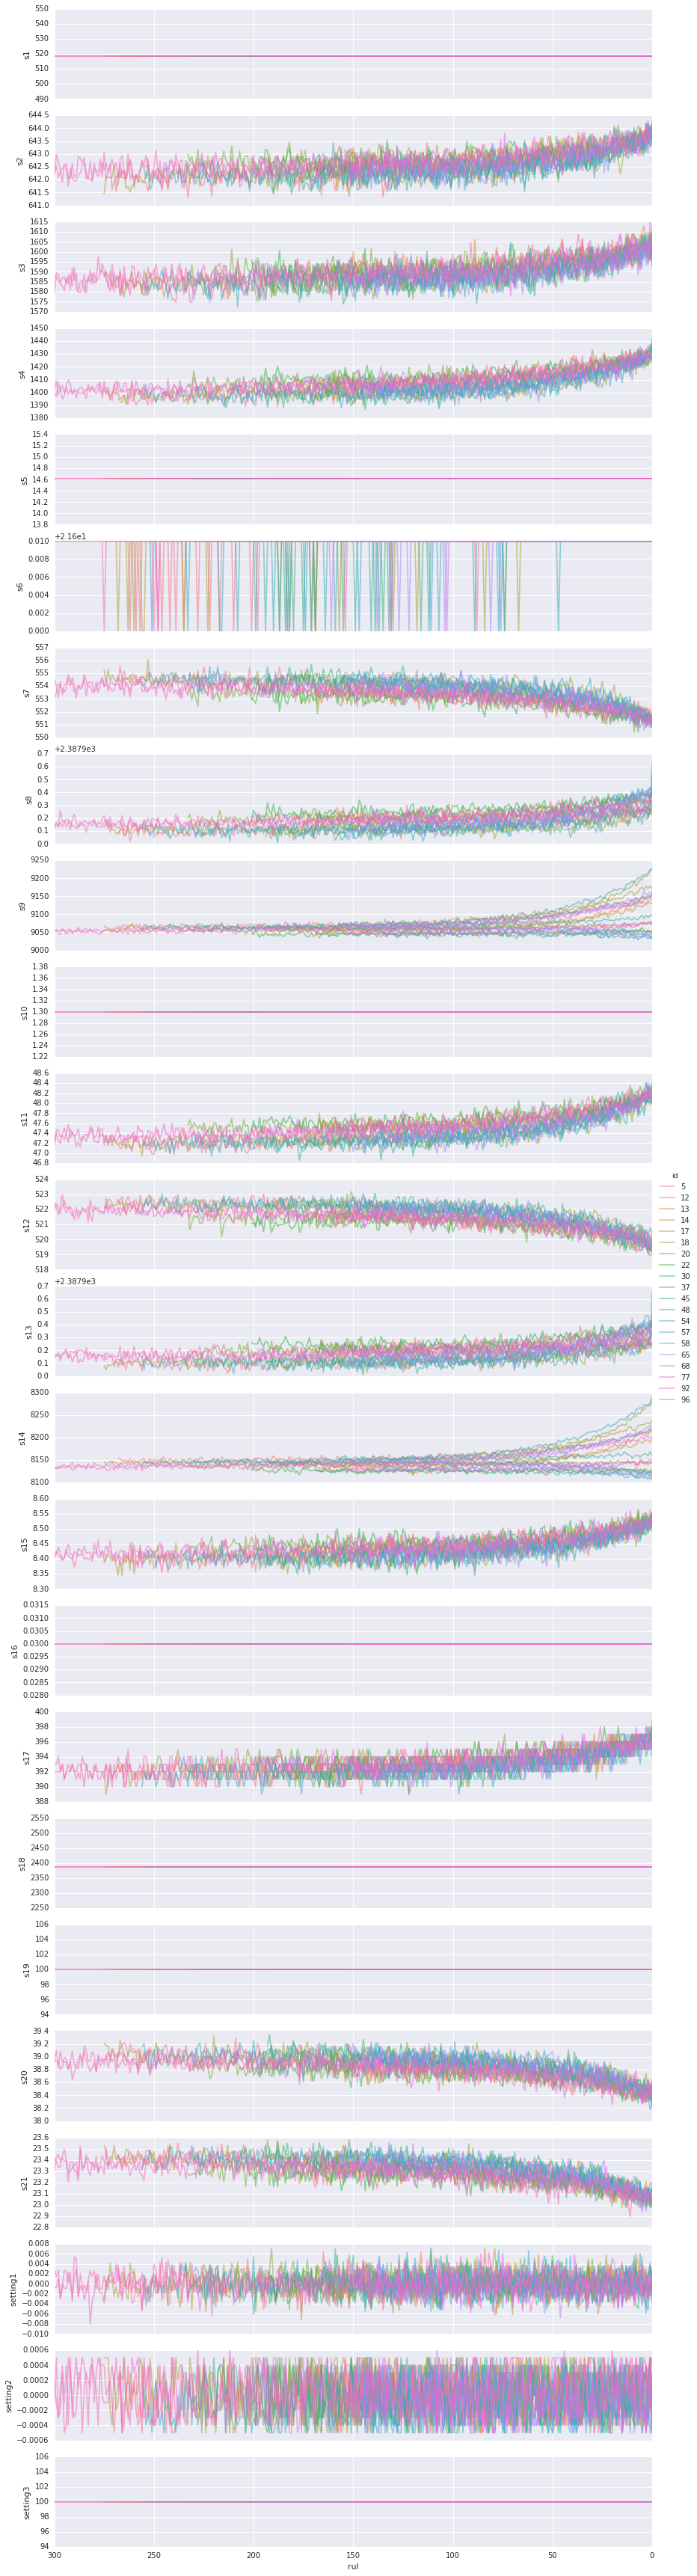

In [17]:
g = sns.PairGrid(data=data,
                 x_vars="rul",
                 y_vars=sensor_measure_columns_names + \
                        operational_settings_columns_names,
                 hue="id", size=2, aspect=6,)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

---------------------


----------------------



# Part 2: Make prediction using previously trained models and analyse output



The remaining useful life (RUL) has been transformed into labels indicating that we approaching a failure. For the  "label1", "0" means that everything is OK and "1" is set when the RUL is smaller than an arbitrary threshold, here 30 cycles. For "label2", we additionaly the value "2" is triggerred when the failure is imminent, here less than 15 cycles. 


<img src="https://az712634.vo.msecnd.net/samplesimg/v1/T4/labeling_1.png" alt="Drawing" style="width: 400px;"/>



In each case, we have trained models for predicting label1 and label2 using several machine learning algorithm. 
Below, we will use these models to do predictions and compare and evaluate each approach. 


We will report the result primarilly under the form of confusion matrices

![img](http://dni-institute.in/blogs/wp-content/uploads/2015/02/ConfusionMatrix.png)


In the case of label2, because there are three target category values, this is a 3-×-3 matrix, where each row corresponds to an actual correct value, and each column to a predicted value, in order.  The entry at row i and column j counts the number of times an example with true category i was predicted as category j. So, the correct predictions are the counts along the diagonal, and incorrect predictions are everything else. Counts are high along the diagonal, which is good. However, there are certainly a number of misclassifications. [7]


Finally, it’s helpful to summarize the accuracy with a single number. An obvious place to start is to compute the fraction of all examples that were correctly predicted:
   
```
Precision = 0.965440356745
Weighted precision = 0.964996151577

```

This measurement is commonly called accuracy, and is called precision in Spark’s MulticlassMetrics. This is a light overloading of the term. Precision is actually a common metric for binary classification problems, where there are two category values, not several. In a binary classification problem, where there is some kind of positive and negative class, precision is the fraction of examples that the classifier marked positive that are actually positive. [7]


NB: Below, we will use only dataset "001". Analyzing other datasets in a similar fashion is left as an excercise to the reader ;)


-----

Let's start by creating a helper function for displaying confusion matrices

In [18]:
from pyspark.mllib.linalg import Vectors, DenseMatrix 
import numpy as np

def display_cm(m):
    a = m.toArray()
    row_sums = a.astype(np.float64).sum(axis=1).astype(np.float64)
    percentage_matrix = 100.0* a.astype(np.float64) / row_sums[:, np.newaxis]
    plt.figure(figsize=(3, 3))
    dims = (8,8)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percentage_matrix, annot=True,  fmt='.2f', xticklabels=['0' ,'1','2'], yticklabels=['0' ,'1','2']);
    plt.title('Confusion Matrix');
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    


And a function to easily run the models we have learned previously in scala

In [19]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.sql import SQLContext


def runmodel(modelpath,datasetpath,label_col,modeltype=""):
    
    ###################################################################################################
    # Load the model 
    # Currently in Spark, one must know the type of model before loading it. 
    # This inconvenience is partly solved by pipelines (see Santander example)
    ###################################################################################################
    
    if modeltype == "LR":
        model =  LogisticRegressionModel.load(sc, modelpath)
    elif modeltype == "RF":
         model = RandomForestModel.load(sc, modelpath)
    else:
        print "Please specify model type, LR or RF"
        return 
    
              
    data = sqlContext.read.parquet(datasetpath)
    print("Read %s items from dataset" % data.count())

        
    ###################################################################################################
    #
    #  We now need to prepare the data the same way we did before learning the model (see Scala code)
    #  A way to avoid this that is currently 'work in progress' in Spark is to use pipelines 
    #  (see the Santander bank's example)
    #
    ###################################################################################################
      
    # Index labels
    indexer = StringIndexer(inputCol=label_col, outputCol="indexedLabel").fit(data)
    indexedDF = indexer.transform(data)

    
    # Create an RDD suitable for the ML algorithm
    labeledRDD = indexedDF.select(col("indexedLabel").alias("label"), 
                                  col("scaledFeatures").alias("features")
                                ).map(lambda row:  LabeledPoint(row.label, row.features))
        
    
    ###################################################################################################
    #
    # Use the model to do the prediction
    # for each item in the dataset and create an RDD, i.e. ~ a list of tuples (prediction,true label)
    #
    #
    ###################################################################################################
    
    
    if modeltype == "RF":   
        predictions = model.predict(labeledRDD.map(lambda x: x.features))
        predictionAndLabels = labeledRDD.map(lambda x: x.label).zip(predictions)
    elif modeltype == "LR":
        predictionAndLabels = labeledRDD.map(lambda lp: (float(model.predict(lp.features)), lp.label))

    #NB: The above is a hack to circumvent issues (partly) described in here:
    #http://stackoverflow.com/questions/31684842/how-to-use-java-scala-function-from-an-action-or-a-transformation
    
    
    
    ###################################################################################################
    #
    # Everything below is only for evaluating the performances of the model
    #
    ###################################################################################################
    
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    # Overall statistics
    precision = metrics.precision()
    recall = metrics.recall()
    f1Score = metrics.fMeasure()
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    # Statistics by class SF
    labels = labeledRDD.map(lambda lp: lp.label).distinct().collect()
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    df_confusion = metrics.confusionMatrix()
    print (df_confusion)
    display_cm(df_confusion);
    return predictionAndLabels

### Run the model on training data

In here, we will run the model the training data, i.e. data that has been shown to the model during the training phase, and compare predictions with the labels calculated from the known RUL. 


Read 20631 items from dataset
Summary Stats
Precision = 0.948863360962
Recall = 0.948863360962
F1 Score = 0.948863360962
Class 0.0 precision = 0.97583611567
Class 0.0 recall = 0.983629000057
Class 0.0 F1 Measure = 0.979717061531
Class 1.0 precision = 0.890274314214
Class 1.0 recall = 0.8925
Class 1.0 F1 Measure = 0.89138576779
Class 2.0 precision = 0.666666666667
Class 2.0 recall = 0.602666666667
Class 2.0 F1 Measure = 0.633053221289
Weighted recall = 0.948863360962
Weighted precision = 0.946722012823
Weighted F(1) Score = 0.947662103926
Weighted F(0.5) Score = 0.947064387385
Weighted false positive rate = 0.119479940055
DenseMatrix([[  1.72440000e+04,   1.00000000e+00,   2.86000000e+02],
             [  6.00000000e+00,   1.42800000e+03,   1.66000000e+02],
             [  4.21000000e+02,   1.75000000e+02,   9.04000000e+02]])


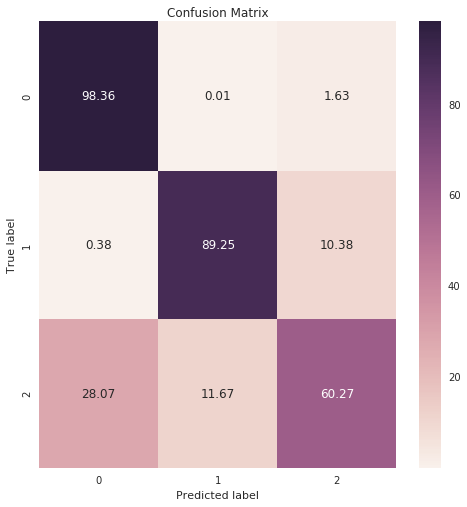

In [20]:
lr_label2 = runmodel("/share/tedsds/lr_model_FD001_label2","/share/tedsds/scaleddftrain_FD001","label2","LR")

#### What does this mean in this context? 

We are successful 98% of time in finding when label2 should be 0 (all OK), 89% when label2 should be 1 (30 cycles or less from breakdown) and  60% when label2 should be 2 (15 cycles or less from breakdown). 

We remark that we totally miss the failure in 28% of case, where we continue to predict that everything is ok while the failure is imminent. We also mislabel states 1 and 2 in 10% of cases, which is less of a problem in practice (i.e. the failure is predicted, but the time to failure is inaccurate). 




We will now compare with a model where we predict only the simpler label1: 

Read 20631 items from dataset
Summary Stats
Precision = 0.965440356745
Recall = 0.965440356745
F1 Score = 0.965440356745
Class 0.0 precision = 0.976376614548
Class 0.0 recall = 0.983115623752
Class 0.0 F1 Measure = 0.979734530881
Class 1.0 precision = 0.900637797919
Class 1.0 recall = 0.865483870968
Class 1.0 F1 Measure = 0.882710972199
Weighted recall = 0.965440356745
Weighted precision = 0.964996151577
Weighted F(1) Score = 0.965155837075
Weighted F(0.5) Score = 0.965044651985
Weighted false positive rate = 0.116840862025
DenseMatrix([[ 17235.,    296.],
             [   417.,   2683.]])


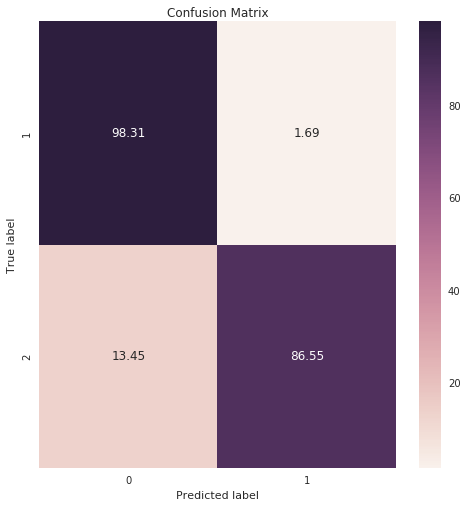

In [21]:
lr_label1 = runmodel("/share/tedsds/lr_model_FD001_label1","/share/tedsds/scaleddftrain_FD001","label1","LR")

To make a fair comparison, we take the result for the model predicting label2 and transform "2" to "1":

In [22]:
def merge_labels(inputpredictionAndLabels):
    
    def drop2(x):
        if x==2.0:
            return 1.0
        return x
    
    predictionAndLabels = inputpredictionAndLabels.map(lambda x: (drop2(x[0]),drop2(x[1])))
     # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    # Overall statistics
    precision = metrics.precision()
    recall = metrics.recall()
    f1Score = metrics.fMeasure()
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    # Statistics by class SF
    labels = [0.0,1.0]
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    df_confusion = metrics.confusionMatrix()
    print (df_confusion)
    display_cm(df_confusion);
    return predictionAndLabels

Summary Stats
Precision = 0.965391885997
Recall = 0.965391885997
F1 Score = 0.965391885997
Class 0.0 precision = 0.97583611567
Class 0.0 recall = 0.983629000057
Class 0.0 F1 Measure = 0.979717061531
Class 1.0 precision = 0.903040540541
Class 1.0 recall = 0.862258064516
Class 1.0 F1 Measure = 0.882178217822
Weighted recall = 0.965391885997
Weighted precision = 0.964897902161
Weighted F(1) Score = 0.965060941348
Weighted F(0.5) Score = 0.964942352462
Weighted false positive rate = 0.119504821424
DenseMatrix([[ 17244.,    287.],
             [   427.,   2673.]])


PythonRDD[215] at RDD at PythonRDD.scala:43

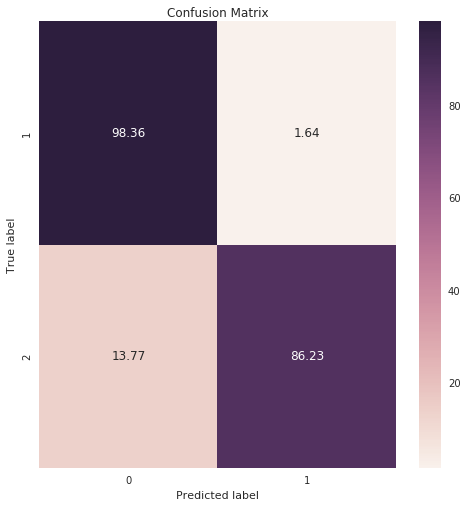

In [23]:
merge_labels(lr_label2)

Thus the two models lead to nearly identical results once the label2 has been collapsed onto label1. Is this the case for all datasets ? --- Check it! =)


### Evaluate the model on test data
We now perform the same operations but on the test data, i.e. data that has not been shown to the model previously.

Read 13096 items from dataset
Summary Stats
Precision = 0.877748930971
Recall = 0.877748930971
F1 Score = 0.877748930971
Class 0.0 precision = 0.998935037274
Class 0.0 recall = 0.8818552178
Class 0.0 F1 Measure = 0.936750998668
Class 1.0 precision = 0.306017925736
Class 1.0 recall = 0.878676470588
Class 1.0 F1 Measure = 0.453941120608
Class 2.0 precision = 0.0
Class 2.0 recall = 0.0
Class 2.0 F1 Measure = 0.0
Weighted recall = 0.877748930971
Weighted precision = 0.979966683839
Weighted F(1) Score = 0.922431408965
Weighted F(0.5) Score = 0.955735667717
Weighted false positive rate = 0.0364740612069
DenseMatrix([[ 11256.,    482.,   1026.],
             [    12.,    239.,     21.],
             [     0.,     60.,      0.]])


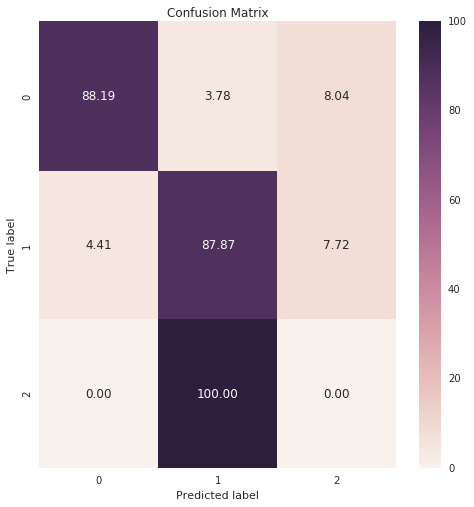

In [24]:
lrtest_label2 = runmodel("/share/tedsds/lr_model_FD001_label2","/share/tedsds/scaleddftest_FD001","label2","LR")

Read 13096 items from dataset
Summary Stats
Precision = 0.905161881491
Recall = 0.905161881491
F1 Score = 0.905161881491
Class 0.0 precision = 0.9986151982
Class 0.0 recall = 0.903948605453
Class 0.0 F1 Measure = 0.948926720947
Class 1.0 precision = 0.204928664073
Class 1.0 recall = 0.951807228916
Class 1.0 F1 Measure = 0.337246531483
Weighted recall = 0.905161881491
Weighted precision = 0.978494250633
Weighted F(1) Score = 0.933419862143
Weighted F(0.5) Score = 0.959493709207
Weighted false positive rate = 0.049406047122
DenseMatrix([[ 11538.,   1226.],
             [    16.,    316.]])


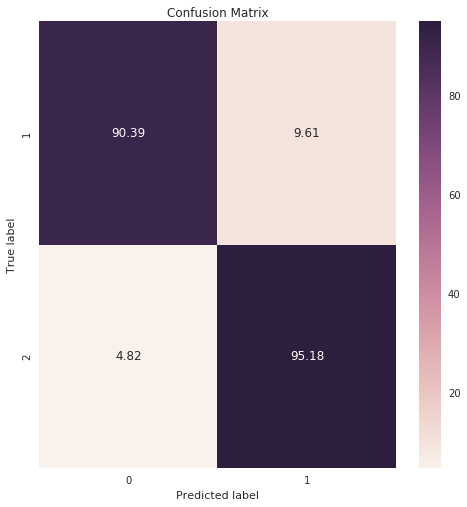

In [25]:
lrtest_label1=runmodel("/share/tedsds/lr_model_FD001_label1","/share/tedsds/scaleddftest_FD001","label1","LR")

Summary Stats
Precision = 0.883934025657
Recall = 0.883934025657
F1 Score = 0.883934025657
Class 0.0 precision = 0.998935037274
Class 0.0 recall = 0.8818552178
Class 0.0 F1 Measure = 0.936750998668
Class 1.0 precision = 0.175054704595
Class 1.0 recall = 0.963855421687
Class 1.0 F1 Measure = 0.296296296296
Weighted recall = 0.883934025657
Weighted precision = 0.978048639103
Weighted F(1) Score = 0.920514669928
Weighted F(0.5) Score = 0.953733515097
Weighted false positive rate = 0.0382233861699
DenseMatrix([[ 11256.,   1508.],
             [    12.,    320.]])


PythonRDD[326] at RDD at PythonRDD.scala:43

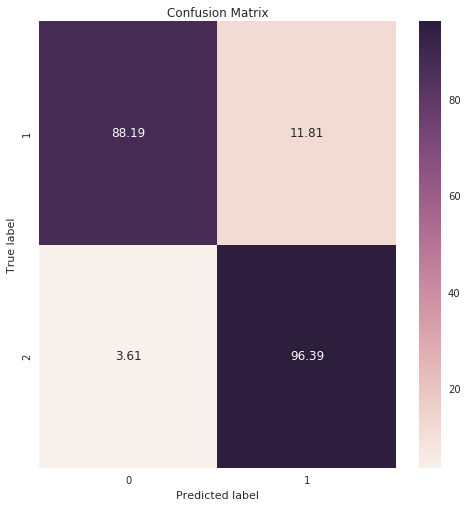

In [26]:
merge_labels(lrtest_label2)

The model is fairly good at predicting that a failure is approaching, but can't resolve between <15 and <30 cycles of RUL.

NB: Because test data has not been shown to the model during training, we should expect lower accuracy on test data than on training data. In this particular case, we observe the opposite --- Probably our lucky day :)

### Random forest

So far, we have used a model based on a logistic classifier. We now perform the same steps as above but for a random forest classifier. We look at the two RF models learned previously, "rf2" being a lot more complex than "rf" (more trees, bigger maximal tree depth).


Read 20631 items from dataset
Summary Stats
Precision = 0.937521205952
Recall = 0.937521205952
F1 Score = 0.937521205952
Class 0.0 precision = 0.98996064115
Class 0.0 recall = 0.963791858722
Class 0.0 F1 Measure = 0.976700996117
Class 1.0 precision = 0.86
Class 1.0 recall = 0.834445118253
Class 1.0 F1 Measure = 0.84702985534
Class 2.0 precision = 0.407333333333
Class 2.0 recall = 0.626666666667
Class 2.0 F1 Measure = 0.493737373737
Weighted recall = 0.937521205952
Weighted precision = 0.952038740981
Weighted F(1) Score = 0.943512239248
Weighted F(0.5) Score = 0.948402439144
Weighted false positive rate = 0.0616229501623
DenseMatrix([[  1.73550000e+04,   2.10000000e+01,   6.31000000e+02],
             [  1.50000000e+01,   1.37600000e+03,   2.58000000e+02],
             [  1.61000000e+02,   2.03000000e+02,   6.11000000e+02]])


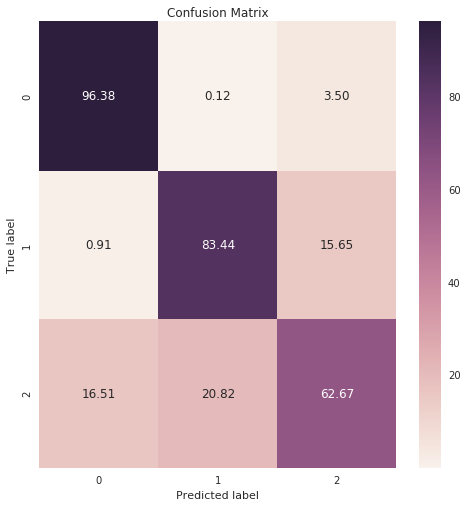

In [27]:
rf_label2 = runmodel("/share/tedsds/rf_model_FD001_label2","/share/tedsds/scaleddftrain_FD001","label2","RF")

Read 20631 items from dataset
Summary Stats
Precision = 0.952062430323
Recall = 0.952062430323
F1 Score = 0.952062430323
Class 0.0 precision = 0.988648679482
Class 0.0 recall = 0.973598472082
Class 0.0 F1 Measure = 0.981065859112
Class 1.0 precision = 0.8825
Class 1.0 recall = 0.910967741935
Class 1.0 F1 Measure = 0.896507936508
Class 2.0 precision = 0.598666666667
Class 2.0 recall = 0.702111024238
Class 2.0 F1 Measure = 0.646275638719
Weighted recall = 0.952062430323
Weighted precision = 0.9564971867
Weighted F(1) Score = 0.953958037294
Weighted F(0.5) Score = 0.955411689264
Weighted false positive rate = 0.0633659365751
DenseMatrix([[  1.73320000e+04,   6.00000000e+00,   4.64000000e+02],
             [  0.00000000e+00,   1.41200000e+03,   1.38000000e+02],
             [  1.99000000e+02,   1.82000000e+02,   8.98000000e+02]])


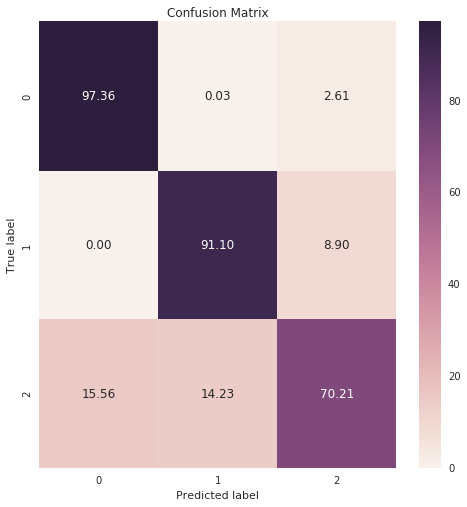

In [28]:
rf2_label2 = runmodel("/share/tedsds/rf2_model_FD001_label2","/share/tedsds/scaleddftrain_FD001","label2","RF")

The RF models do better than the logistic classifier on the train data.
The most complex model rf2 is clearly better. Compare the runtime of both models! Is rf2 worth the extra efforts ? 


Let's run the same model on the __test data__: 

Read 13096 items from dataset
Summary Stats
Precision = 0.953649969456
Recall = 0.953649969456
F1 Score = 0.953649969456
Class 0.0 precision = 0.966546537136
Class 0.0 recall = 0.996365692134
Class 0.0 F1 Measure = 0.981229619025
Class 1.0 precision = 0.558823529412
Class 1.0 recall = 0.5
Class 1.0 F1 Measure = 0.527777777778
Class 2.0 precision = 0.0
Class 2.0 recall = 0.0
Class 2.0 F1 Measure = 0.0
Weighted recall = 0.953649969456
Weighted precision = 0.926822050684
Weighted F(1) Score = 0.939983933049
Weighted F(0.5) Score = 0.932026706
Weighted false positive rate = 0.565799671389
DenseMatrix([[ 12337.,     45.,      0.],
             [    92.,    152.,     60.],
             [   335.,     75.,      0.]])


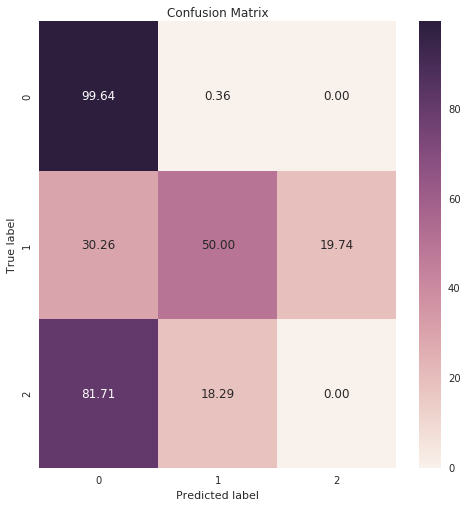

In [29]:
rftest_label2 = runmodel("/share/tedsds/rf_model_FD001_label2","/share/tedsds/scaleddftest_FD001","label2","RF")

Read 13096 items from dataset
Summary Stats
Precision = 0.966249236408
Recall = 0.966249236408
F1 Score = 0.966249236408
Class 0.0 precision = 0.969288624256
Class 0.0 recall = 0.995974883272
Class 0.0 F1 Measure = 0.982450567776
Class 1.0 precision = 0.849397590361
Class 1.0 recall = 0.418397626113
Class 1.0 F1 Measure = 0.560636182903
Weighted recall = 0.966249236408
Weighted precision = 0.963118300734
Weighted F(1) Score = 0.960741427931
Weighted F(0.5) Score = 0.960603935171
Weighted false positive rate = 0.551876727024
DenseMatrix([[ 12372.,     50.],
             [   392.,    282.]])


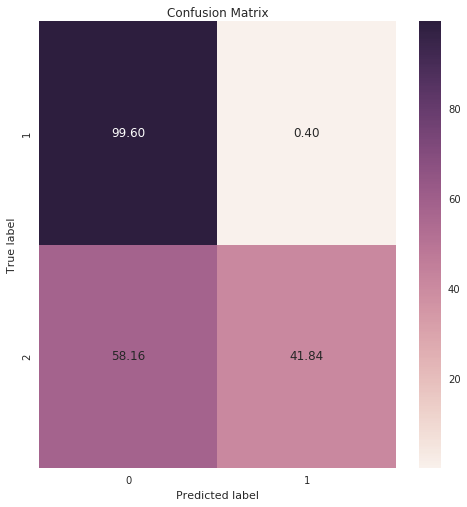

In [30]:
rftest_label1 = runmodel("/share/tedsds/rf_model_FD001_label1","/share/tedsds/scaleddftest_FD001","label1","RF")

Read 13096 items from dataset
Summary Stats
Precision = 0.956093463653
Recall = 0.956093463653
F1 Score = 0.956093463653
Class 0.0 precision = 0.968583516139
Class 0.0 recall = 0.996533935193
Class 0.0 F1 Measure = 0.982359952324
Class 1.0 precision = 0.580882352941
Class 1.0 recall = 0.568345323741
Class 1.0 F1 Measure = 0.574545454545
Class 2.0 precision = 0.0
Class 2.0 recall = 0.0
Class 2.0 F1 Measure = 0.0
Weighted recall = 0.956093463653
Weighted precision = 0.929881826156
Weighted F(1) Score = 0.94279789286
Weighted F(0.5) Score = 0.935003725971
Weighted false positive rate = 0.550876996085
DenseMatrix([[ 12363.,     43.,      0.],
             [    60.,    158.,     60.],
             [   341.,     71.,      0.]])


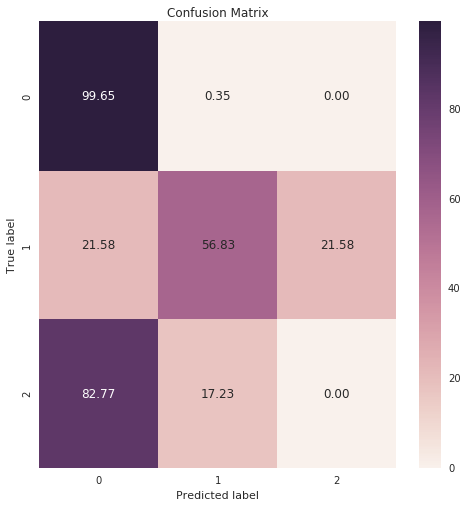

In [31]:
rf2test_label2 = runmodel("/share/tedsds/rf2_model_FD001_label2","/share/tedsds/scaleddftest_FD001","label2","RF")

Read 13096 items from dataset
Summary Stats
Precision = 0.964874770922
Recall = 0.964874770922
F1 Score = 0.964874770922
Class 0.0 precision = 0.966703227828
Class 0.0 recall = 0.997171488605
Class 0.0 F1 Measure = 0.981701010422
Class 1.0 precision = 0.894578313253
Class 1.0 recall = 0.41135734072
Class 1.0 F1 Measure = 0.563567362429
Weighted recall = 0.964874770922
Weighted precision = 0.962726884798
Weighted F(1) Score = 0.958648743024
Weighted F(0.5) Score = 0.958960284683
Weighted false positive rate = 0.556345941597
DenseMatrix([[ 12339.,     35.],
             [   425.,    297.]])


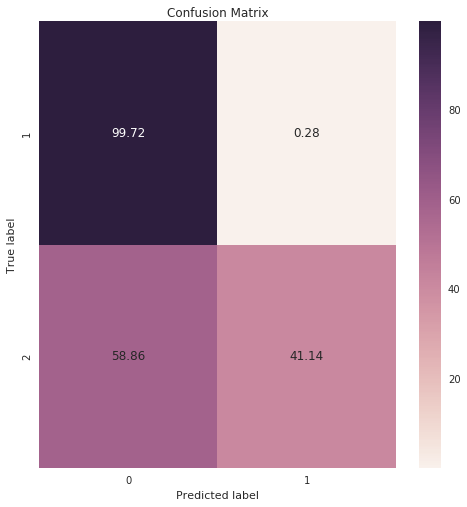

In [32]:
rf2test_label1 = runmodel("/share/tedsds/rf2_model_FD001_label1","/share/tedsds/scaleddftest_FD001","label1","RF")

On the test data, the results are pretty bad! --- The models are __overfitted to the training data__.